In [1]:
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
from local_functions import *

# Tutorial on running simulations of tree ant foraging 🐜

We show how to use the `AntNetwork` class to simulate the moving of foraging tree ants. For a quick start, we first demonstrate the top-level functions that start simulations of tree ants that move between two nests. The `AntNetwork` class is quite flexible and can be used to simulate tree-ant movement between several nests (and food sources*). In the second part of this tutorial, we demonstrate the functions that one can use to manipulate ant networks. 

*Behaviour of ants at food sources is not fully implemented yet. 

## 1. Quick start: The two-nest case

The function `run_abm(g, gname)` runs an agent-based model on a network `g` with two nests and stores simulation data in a folder `gname`. One can specify various model parameters. For example, the command `run_abm(g, gname, visibility=0.9, iterations=50, ants=100, algorithm='noisyRankEdge', noise=0.1, q_explore=0.2, q_decay=0.02, volatility=1, timesteps=1000, sampling_rate=10)` runs 50 iterations of an agent-based model on a network `g` with 100 ants that use the "noisyRankEdge" algorithm with parameters $q_{\textrm{noise}}=0.1$, $q_{\textrm{explore}}=0.2$ and $q_{\textrm{decay}}=0.02$ for 1000 timesteps. At the start of the simulation, 90% of edges in `g` are visible and, at each time step, on edge vanishes and another edge appears. For each iteration, results are sampled every 10 time steps. The results are saved to four npy files: 

1. a `t x m` boolean array that indicates whether an edge was present or "invisible at a timestep in the simulation (here `t` is the number of timesteps),
2. a `t x m` float array that indicates the pheromone level on an edge at a timestep in the simulation,
3. a `t x m` boolean array that indicates ant sightings on an edge at a timestep in the simulation, and
4. a `t x 2` integer array that indicates the number of arrivals at each nest at a timestep in the simulation.

To learn where `run_abm` has stored these files, use the command `run_filenames()` with the same keywords as `run_abm()`.

The code snippet below runs a very short simulation of the movement of tree ants.

In [2]:
t0 = time.time()

# create a lattice graph
g1 = spatial_lattice_graph(lattice=(11,11))
# create filename for the graph
gname = graph_filename(lattice=(11,11))
# run simulation
run_abm(g1, gname, iterations=1, ants=100, algorithm='noisyRankEdge', noise=0.2, 
        q=None, q_explore=0.2, q_power=2.0, q_decay=0.02,
        volatility=1, timesteps=100, sampling_rate=10)

print(time.time()-t0)

i 0
0.8775291442871094


## 2. Demo of functions in the `AntNetwork` class

In this part of the tutorial, we introduce the `AntNetwork` class and its functions.

### 2.1. Attributes of an `AntNetwork`
The `AntNetwork` class is a subclass of the networkx `DiGraph`. In addition to the standard `DiGraph` attributes, an `AntNetwork` has several attributes for its nodes and edges. Nodes in an `AntNetwork` have the Boolean attribute `is_nest` that indicates whether a node is a nest or not. Nodes also have the real-valued attribute `nutrients` that indicates the amount of nutrients available at a node. Edges in an `AntNetwork` have the Boolean attribute `is_visible` that indicates whether an edge is currently present in the time-varying network on which the ants move. They also have a real-valued attribute `pheromone` that indicates the amount of pheromone on an edge. The edge attribute `ants` is a list that contains all ants that are currently on an edge. 

### 2.2. Interpretation of positions of ants
In our simulations, ant positions are edges rather than nodes. (This choice helps to increase the simplicity of the code and to decrease the run time.) Generally, an ant being on an edge $(i,j)$ at time step $t$ means that the ant traverses the edge from $i$ to $j$ in time step $t$. It arrives at the $j$-end of the edge $(i,j)$ at the end of time step $t$ and will attempt to cross the node $j$ and travel along another edge in the next time step.

To allow ants to stay at nests or food sources, we include self-edges at nests and food sources. An ant traversing a self-edge $(i,i)$ indicates that the ant simply stays at node $i$.

### 2.3. Initializing an `AntNetwork`
To initialize an instance of `AntNetwork`, create a networkx graph `g` that you would like to as a model for a canopy. Then, call `AntNetwork(graph=g)`. For example:

In [3]:
g = spatial_lattice_graph(lattice=(5,5))
an = AntNetwork(graph=g)

### 2.4. Associated graphs
We would like to simulate the movement of ants on a canopy that changes over time. For this purpose, each instance of  `AntNetwork` has two associated graphs: a static graph and a temporal graph.
The static graph includes all *possible* edges in the canopy. The temporal graph includes only the edges that are present (i.e., visible to and traversible by ants) at a given point in time. The temporal graph can be different for different time points in a simulation. At every time point, the temporal graph is a subgraph of the static graph. The static graph does not change over time. We set the static graph when initializing an instance of `AntNetwork`. In Section 2.3. the static graph was `g`.

We can get the static graph via the `get_graph()` function and the temporal graph via the `get_temporal_graph()` function.

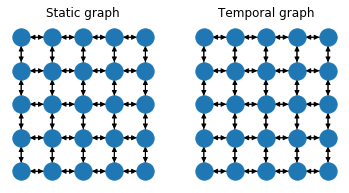

In [4]:
plt.figure(figsize=(6,3))

# get position of nodes
pos = {i: an.nodes[i]['position'] for i in range(an.number_of_nodes())}

# draw static graph
plt.subplot(121)
plt.title('Static graph')
nx.draw(an.get_graph(), pos) # GIVES DIRECTED GRAPH
#nx.draw(nx.Graph(an.get_graph()), pos) #TOGGLE FOR UNDIRECTED GRAPH!

# draw temporal graph
plt.subplot(122)
plt.title('Temporal graph')
nx.draw(an.get_temporal_graph(), pos) # GIVES DIRECTED GRAPH
#nx.draw(nx.Graph(an.get_temporal_graph()), pos) # TOGGLE FOR UNDIRECTED GRAPH!

We have not manipulated the temporal graph in any way. Because of this the temporal graph is just a copy of the static graph. Note that the static graph and the temporal graph are directed graphs with bidirectional edges. One can get undirected graphs by applying `nx.Graph()` on the static graph and the temporal graph. See the toggle options in the example above.

### 2.5. Node attributes

Nodes in an AntNetwork can be locations of nests or food sources. In this section, we demonstrate how to set, manipulate, and view the locations of nests and food sources in an AntNetwork.

#### 2.5.1 Nests

Tree ants can have several nests. We assume that these nests are located at nodes in a canopy. The function `an.add_nest(i)` adds a nest at node `i` in the AntNetwork `an`. The function `an.remove_nest(i)` removes the nest at node `i`. The function `an.set_nests([i,j])` adds nests to the nodes `i` and `j` and removes nests at all other nodes. There can be at most one nest at a node. The Boolean node attribute `"is_nest"` indicates whether a nest is located at a node. We can get a list of all nodes that currently have nests on them via `an.get_nests()`. Here is an example:

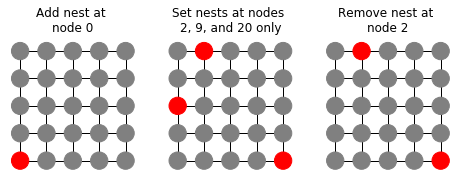

In [5]:
plt.figure(figsize=(8,2.5))

plt.subplot(131)
plt.title('Add nest at \nnode 0')
an.add_nest(0) # add nest at node 0
nx.draw(nx.Graph(an.get_graph()), pos, node_color=color_nodes(an)) 

plt.subplot(132)
plt.title('Set nests at nodes \n2, 9, and 20 only')
an.set_nests([2,9,20]) # set nests at nodes 2, 9, and 20
nx.draw(nx.Graph(an.get_graph()), pos, node_color=color_nodes(an))

plt.subplot(133)
plt.title('Remove nest at \nnode 2')
an.remove_nest(2) # remove nest at node 2
nx.draw(nx.Graph(an.get_graph()), pos, node_color=color_nodes(an))

In the above example, we use the function `color_nodes(an)` to produce a color assignment for nodes in `an`. By default, nodes with nests are coloured red, nodes with food are coloured blue, and all other nodes are coloured grey. You can change the colour settings by using the keyword arguments in `color_nodes(an, nest="red", food="blue", other="grey")`. We see from the last panel that, currently, the AntNetwork `an` has two nests, which are located at nodes 9 and 20. We can get this information via the function `an.get_nests()`.

In [6]:
an.get_nests()

[9, 20]

Our default simulation setup includes two nests. We can generate this setup using the function `an.set_two_nests()`. This function places one nest on the node that is furthest to left in the spatial network (i.e., the node with the smallest horizontal coordinate) and the other nest on the node that is furthest to the right (i.e., the node with the largest horizontal coordinate). If several nodes have the smallest horizontal coordinate, it chooses the one with the smallest vertical coordinate to be the left nest. If several nodes have the largest horizontal coordinate, it chooses the one with the largest vertical coordinate to be the right nest. On a 2d grid, this means that we usually get one nest in the bottom left corner and one nest in the top right corner.

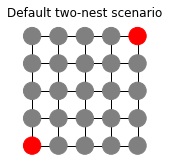

In [7]:
plt.figure(figsize=(8,2.5))
plt.subplot(132)
plt.title('Default two-nest scenario')
an.set_two_nests() # add nest at node 0
nx.draw(nx.Graph(an.get_graph()), pos, node_color=color_nodes(an)) 

#### 2.5.1 Food sources
Food can be located at nodes in the canopy network. The function `an.add_foodsource(i, amount=100)` adds a food source with 100 units of food at node `i` in the AntNetwork `an`. The function `an.remove_foodsource(i)` removes the food source at node `i` (i.e., it sets the amount of food at node `i` to 0). The function `an.set_foodsources([i,j], amount=100)` adds food sources with 100 units of food to the nodes `i` and `j` and removes all other food sources. Here is an example:

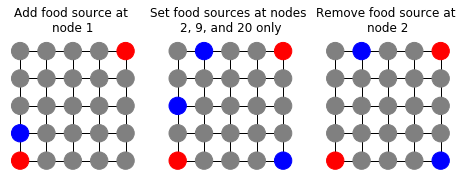

In [8]:
plt.figure(figsize=(8,2.5))

plt.subplot(131)
plt.title('Add food source at \nnode 1')
# add food source at node 1
an.add_foodsource(1)
nx.draw(nx.Graph(an.get_graph()), pos, node_color=color_nodes(an)) 

plt.subplot(132)
plt.title('Set food sources at nodes \n2, 9, and 20 only')
# set food sources at nodes 2, 9, and 20 with 50 food units each
an.set_foodsources([2,9,20], amount=50) 
nx.draw(nx.Graph(an.get_graph()), pos, node_color=color_nodes(an))

plt.subplot(133)
plt.title('Remove food source at \nnode 2')
# remove food source at node 2
an.remove_foodsource(2)
nx.draw(nx.Graph(an.get_graph()), pos, node_color=color_nodes(an))

The real-valued node attribute `"nutrients"` indicates the amount of food at a node. If the amount of food is greater than 0, we consider a node to have a food source. We can get a list of all nodes that currently have food sources on them via `an.get_foodsources()`. This function returns a list of tuples consisting of a node index and the associated amount of food. 

In [9]:
an.get_foodsources()

[(9, 50), (20, 50)]

### 2.6 Edge attributes
Edges in an AntNetwork can be visible or invisible to ants. They also have an associated amount of pheromone. In this section, we demonstrate how to set, manipulate, and view pheromone amounts and edge visibility.

#### 2.6.1 Pheromones
When ants traverse edges in a canopy, they tend to mark their path with pheromone. The amount of pheromone on an edge is important because it affects an ant's navigation in the canopy. The real-valued edge attribute `"pheromone"` indicates the amount of pheromone on an edge.

The function `an.add_pheromone(i,j, amount=1)` adds one unit of pheromone to the edge `(i,j)`. The default amount of pheromone is 1, so calling `an.add_pheromone(i,j)` is sufficient to add 1 unit of pheromone to the edge `(i,j)`. The effect of calling `an.add_pheromone(i,j)` is the same as calling `an.add_pheromone(j,i)` because the amount of pheromone on an edge is independent of edge direction.

In [10]:
# initial pheromone value is 0
print(an[0][1]['pheromone'])

# add one unit of pheromone to edge (0,1)
an.add_pheromone(0,1)
print(an[0][1]['pheromone'])

# add another unit of pheromone to edge (0,1)
an.add_pheromone(1,0)
print(an[0][1]['pheromone'])

0.0
1.0
2.0


We can get the current pheromone values for all edges using `an.get_pheromone()`. The output is an array of pheromone values.

In [11]:
an.get_pheromone()

array([2., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

The non-zero entries of this array correspond to the directed edges `(0,1)` and `(1,0)`, which have the same pheromone value. 

We can set the pheromone values for all edges using `an.set_pheromone(edge_dict)`, where `edge_dict` is an edge dictionary of pheromone amounts. This also works if `edge_dict` does not contain a pheromone value for every edge in `an`. The pheromone value for edges not included in `edge_dict` is set to 0 - regardless of its previous value! - when we call `an.set_pheromone(edge_dict)`. 

In [12]:
an.set_pheromone({(0,1):1.0,
                  (1,2):2.5})
an.get_pheromone()

array([1. , 0. , 0. , 1. , 2.5, 0. , 0. , 2.5, 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. ])

The function `an.set_pheromone(edge_dict)` is somewhat ruthless when `edge_dict` includes conflicting pheromone values for a directed edge `(i,j)` and its reverse edge `(j,i)`. It will set the pheromone values of `(i,j)` and `(j,i)` to the the value of the whichever of the two directed edges appears last in `edge_dict.keys()`. Python dictionaries are unordered and so the order of keys is not guaranteed. We strongly recommend to make sure that `edge_dict` does not include conflicting pheromone values for two directed edges that correspond to the same directed edge.

In [13]:
an.set_pheromone({(0,1):1.0,
                  (1,0):11.0, #conflicting with value for (0,1)!
                  (1,2):2.5})
an.get_pheromone()

array([11. ,  0. ,  0. , 11. ,  2.5,  0. ,  0. ,  2.5,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ])

Note that to *set* pheromone values, we require a dictionary of edges and pheromone values. When we *get* pheromone values, we get an array.

Pheromones degrade over time. If no ants lay new pheromone on an edge, the amount of pheromone on the edge decreases exponentially as time passes. The function `an.pheromone_decay(q_decay)` simulates this by reducing all pheromone values $c$ in `an` to $(1-q_{\textrm{decay}})\cdot c$, where $q_{\textrm{decay}}$ is the decay parameter.

In [14]:
an.pheromone_decay(0.5) # reduce all pheromone amounts by 50%
an.get_pheromone()

array([5.5 , 0.  , 0.  , 5.5 , 1.25, 0.  , 0.  , 1.25, 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

For the start of most of our simulations, we assume that ants have already found a path that connects their nests. We therefore initialize pheromone amounts on edges using `an.initialize_pheromone(degree=1, amount=5)`. This function sets pheromone values for all edges to 0, except for the edges in a shortest path between nests. One can choose pheromone value for edges on shortest paths using the `amoung` keyword argument. If `an` has more than two nests, one can use the `degree` keyword argument to set the number of pheromone paths that connect a nest with other nests. For example, if `degree=3`, each nest will be connected via pheromone paths to the three closest* nests.

*as measured in Euclidean distance

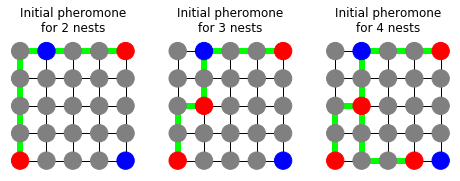

In [15]:
plt.figure(figsize=(8,2.5))

plt.subplot(131)
plt.title('Initial pheromone\nfor 2 nests')
an.initialize_pheromone(degree=1, amount=5)
tg = nx.Graph(an.get_temporal_graph()) # get undirected temporal graph
nx.draw(tg, pos, edges=tg.edges, 
        edge_color=color_edges(tg),
        width=thicken_edges(tg, max_width=6),
        node_color=color_nodes(an))

plt.subplot(132)
plt.title('Initial pheromone\nfor 3 nests')
an.add_nest(7)
an.initialize_pheromone(degree=1, amount=5)
tg = nx.Graph(an.get_temporal_graph())
nx.draw(tg, pos, edges=tg.edges(), 
        edge_color=color_edges(tg),
        width=thicken_edges(tg, max_width=6),
        node_color=color_nodes(an))

plt.subplot(133)
plt.title('Initial pheromone\nfor 4 nests')
an.add_nest(15)
an.initialize_pheromone(degree=1, amount=5)
tg = nx.Graph(an.get_temporal_graph())
nx.draw(tg, pos, edges=tg.edges(), 
        edge_color=color_edges(tg),
        width=thicken_edges(tg, max_width=6),
        node_color=color_nodes(an))

#### 2.6.2 Visibility of edges
To model the temporal changes in vegetation, edges that are "visible" to ants in an AntNetwork can appear, vanish, and reappear over time. The graph `g` that we used to initialize the AntNetwork `an` is the associated static graph that includes all edges that can possibly be visible to ants. Each edge in an AntNetwork has a Boolean attribute `"is_visible"` that indicates whether an edge is currently visible to ants. The temporal graph is the graph of all edges that are currently visible to ants. While it is in principle possible that ants can traverse an edge in one direction but not in the other, we assume for now that either both or none of the directions of an edge are visible and usable by ants. 

The function `an.make_visible(i,j)` sets the visibility of an edge `(i,j)` in `an` to `True`. Because visibility is a property of undirected edges, `an.make_visible(i,j)` and `an.make_visible(j,i)` have the same effect. One can set the visibility of an edge to `False` by calling `an.make_invisible(i,j)` or `an.make_invisible(j,i)`. The function `an.get_visibility()` returns a dictionary of edge visibilities.

In [16]:
# starting out, edge (0,1) is visible
print(an.get_visibility()[(0,1)])

True


In [17]:
# let's make it invisible
an.make_invisible(0,1)
print(an.get_visibility()[(0,1)])

False


In [18]:
# let's make it visible again
an.make_visible(0,1)
print(an.get_visibility()[(0,1)])

True


One can set the visibility of edges using `an.set_visibility(edge_dict)`, where `edge_dict` is a dictionary of edges and Boolean values for edge visibility. When this function is called, the visibility of edges that are not included in `edge_dict` is set to `False`. Self-edges are an exception; if not included in `edge_dict`, they keep their previous visibility value.

In [19]:
# make all non-self edges invisible
an.set_visibility({})
print([e for e in an.edges() if an[e[0]][e[1]]['is_visible']])

[]


In [20]:
# set visibility of edges (0,1), (1,2), and (4,4) to True
an.set_visibility({(0,1): True, 
                   (1,2): True,
                   (4,4): True})
# in the resulting dictionary all other edges are invisible
print([e for e in an.edges() if an[e[0]][e[1]]['is_visible']])

[(0, 1), (1, 0), (1, 2), (2, 1), (4, 4)]


In [21]:
# set visibility of edges (2,3), (5,6), (5,15) to True
an.set_visibility({(2,3): True,
                   (5,6): True,
                   (5,15): True})
# the resulting dictionary still labels (4,4) as visible because
# (4,4) is a self-edge. It does not label (5,15) or (15,5) as 
# visible because these edges are not edges of the static graph
print([e for e in an.edges() if an[e[0]][e[1]]['is_visible']])

[(2, 3), (3, 2), (4, 4), (5, 6), (6, 5)]


The visibility of `(i,j)` and `(j,i)` is the same. When `edge_dict` includes conflicting visibility values for and edge and its reverse, it picks whatever value appears second in the dictionary (see also `an.set_pheromone()` in 2.6.1). 

In [22]:
# try with a dictionary with conflicting values
an.set_visibility({(0,1): True, 
                   (1,0): False, # conflicting with vlaue for (0,1)!
                   (1,2): True})
# in most cases the resulting dictionary does not (0,1) label as visible
print([e for e in an.edges() if an[e[0]][e[1]]['is_visible']])

[(1, 2), (2, 1), (4, 4)]


We use self-edge traversal to model an ant staying at a nest or a food source. Because we do not allow ants to stay at nodes that are not nests or food sources (unless they are queueing or trapped), only self-edges at nodes that have nests or food sources are visible. When locations of nests or food sources change, it can be necessary to update the visibility of self-edges. The function `an.update_selfedge_visibility()` updates the visibility of self-edges based on whether nodes are locations of nests or food sources.

In [23]:
an.update_selfedge_visibility()
# now (4,4) is not visible anymore but self-edges at nodes 
# with nests or food sources are visible
print([e for e in an.edges() if an[e[0]][e[1]]['is_visible']])

[(0, 0), (1, 2), (2, 1), (7, 7), (9, 9), (15, 15), (20, 20), (24, 24)]


When initializing an AntNetwork, it is likely that one does not want all of the edges of the static graph to be visible. The function `an.initialize_temporal_graph()` sets the visibility of a fraction of edges (chosen uniformly at random) to `True` and `False` for the remaining edges. One can specify the fraction of visible edges. Here are some examples of the resulting temporal graphs:

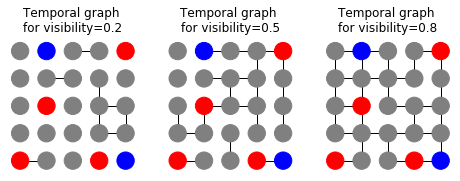

In [24]:
plt.figure(figsize=(8,2.5))

plt.subplot(131)
plt.title('Temporal graph \nfor visibility=0.2')
an.initialize_temporal_graph(visibility=0.2, connected=False)
nx.draw(nx.Graph(an.get_temporal_graph()), pos, node_color=color_nodes(an))

plt.subplot(132)
plt.title('Temporal graph \nfor visibility=0.5')
an.initialize_temporal_graph(visibility=0.5, connected=False)
nx.draw(nx.Graph(an.get_temporal_graph()), pos, node_color=color_nodes(an))

plt.subplot(133)
plt.title('Temporal graph \nfor visibility=0.8')
an.initialize_temporal_graph(visibility=0.8, connected=False)
nx.draw(nx.Graph(an.get_temporal_graph()), pos, node_color=color_nodes(an))

In addition, one can require that the resulting temporal graph needs to be connected. 

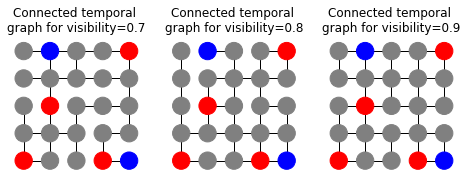

In [25]:
plt.figure(figsize=(8,2.5))

plt.subplot(131)
plt.title('Connected temporal \ngraph for visibility=0.7')
an.initialize_temporal_graph(visibility=0.7, connected=True, max_runs=100)
nx.draw(nx.Graph(an.get_temporal_graph()), pos, node_color=color_nodes(an))

plt.subplot(132)
plt.title('Connected temporal \ngraph for visibility=0.8')
an.initialize_temporal_graph(visibility=0.8, connected=True, max_runs=100)
nx.draw(nx.Graph(an.get_temporal_graph()), pos, node_color=color_nodes(an))

plt.subplot(133)
plt.title('Connected temporal \ngraph for visibility=0.9')
an.initialize_temporal_graph(visibility=0.9, connected=True, max_runs=100)
nx.draw(nx.Graph(an.get_temporal_graph()), pos, node_color=color_nodes(an))

The above call will attempt up to 100 times to generate a connected temporal graph. If, after 100 attempts, it was not able to generate a connected temporal graph, it prints a warning and sets the visibility of all edges to `True`.

One can use the function `an.perturb_temporal_graph(m)` to model structural changes in the vegetation. The function `an.perturb_temporal_graph(m)` changes the visibility of `m` visible edges to `False` and the visibility of `m` invisible edges to `True`. If `m` is not an integer, the function randomly chooses an integer from `[floor(m), ceil(m)]` so that the expected value is `m`.

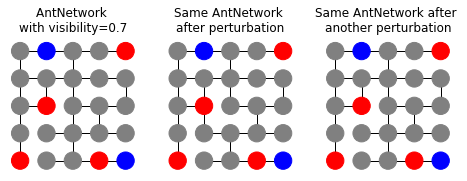

In [26]:
plt.figure(figsize=(8,2.5))

plt.subplot(131)
plt.title('AntNetwork \nwith visibility=0.7')
an.initialize_temporal_graph(visibility=0.7, connected=True, max_runs=100)
nx.draw(nx.Graph(an.get_temporal_graph()), pos, node_color=color_nodes(an))

plt.subplot(132)
plt.title('Same AntNetwork \nafter perturbation')
an.perturb_temporal_graph(1)
nx.draw(nx.Graph(an.get_temporal_graph()), pos, node_color=color_nodes(an))

plt.subplot(133)
plt.title('Same AntNetwork after \nanother perturbation')
an.perturb_temporal_graph(1)
nx.draw(nx.Graph(an.get_temporal_graph()), pos, node_color=color_nodes(an))

### 2.7. Initializing an `AntNetwork` (revisited)
Using several of the functions that we introduced above, a typical initialization for an AntNetwork can look like this:

In [27]:
# make spatial graph
g = spatial_lattice_graph(lattice=(5,5))
# create AntNetwork
an = AntNetwork(graph=g)
# set nests
an.set_two_nests()
# update self-edge visibility
an.update_selfedge_visibility()
# remove some edges
an.initialize_temporal_graph(visibility=0.8, connected=True)
# set initial pheromone paths
an.initialize_pheromone(degree=1)
# ready to go!

### 2.8. Ants

#### 2.8.1. Ant placement
An AntNetwork needs ants! We can add ants to a directed edge `(i,j)` in an AntNetwork `an` by calling `an.add_new_ants(i,j,n)`, where `n` is the number of new ants to be added. We can get the numbers of ants on directed edges by calling `an.get_ant_counts()`. This function returns an array of ant counts. The order of ants counts is the same as the order of edges when calling `an.edges()`.

In [28]:
# add 10 ants to the edge (0,1)
an.add_new_ants(0,1,10)
print(an.get_ant_counts())

[10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0]


In [29]:
# add 15 ants to the edge (1,0)
an.add_new_ants(1,0,10)
print(an.get_ant_counts())

[10  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0]


In [30]:
# add another 10 ants to the edge (0,1)
an.add_new_ants(0,1,10)
print(an.get_ant_counts())

[20  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0]


One can get and set the full lists of ants on each edge. This is relevant, for example, when making a hard copy of an AntNetwork because ants may differ in their attributes and those attributes would get lost when only copying numbers of ants on edges instead of the actual lists of ants on edges. The function `an.get_ants()` returns a dictionary of edges and corresponding lists of ants. The function `an.set_ants(ant_dict)` removes all ants that are currently on `an` and sets the lists of ants on directed edges to the values in `ant_dict`.

In [31]:
an.set_ants({(0,1):2})
print(an.get_ants())

{(0, 1): 2, (0, 5): [], (0, 0): [], (1, 0): [], (1, 2): [], (1, 6): [], (1, 1): [], (2, 1): [], (2, 3): [], (2, 7): [], (2, 2): [], (3, 2): [], (3, 4): [], (3, 8): [], (3, 3): [], (4, 3): [], (4, 9): [], (4, 4): [], (5, 0): [], (5, 6): [], (5, 10): [], (5, 5): [], (6, 1): [], (6, 5): [], (6, 7): [], (6, 11): [], (6, 6): [], (7, 2): [], (7, 6): [], (7, 8): [], (7, 12): [], (7, 7): [], (8, 3): [], (8, 7): [], (8, 9): [], (8, 13): [], (8, 8): [], (9, 4): [], (9, 8): [], (9, 14): [], (9, 9): [], (10, 5): [], (10, 11): [], (10, 15): [], (10, 10): [], (11, 6): [], (11, 10): [], (11, 12): [], (11, 16): [], (11, 11): [], (12, 7): [], (12, 11): [], (12, 13): [], (12, 17): [], (12, 12): [], (13, 8): [], (13, 12): [], (13, 14): [], (13, 18): [], (13, 13): [], (14, 9): [], (14, 13): [], (14, 19): [], (14, 14): [], (15, 10): [], (15, 16): [], (15, 20): [], (15, 15): [], (16, 11): [], (16, 15): [], (16, 17): [], (16, 21): [], (16, 16): [], (17, 12): [], (17, 16): [], (17, 18): [], (17, 22): [], (17,

For most of our simulations, we consider ants to start at nests. To quickly initialize ants on `an`, use `an.populate_nests(n, empty_canopy=True)`. This function adds `n/m` new ants to each nest in `an`, where `m` is the number of nests in `an`. If ` empty_canopy` is `True`, the function removes all existing ants from `an` before placing `n/m` new ants on each nest.

In [32]:
# add 100 ants to the AntNetwork; divide them equally on all nests
an.populate_nests(100, empty_canopy=True)
print(an.get_ant_counts())

[  0   0 100   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0 100]


#### 2.8.2. Ant movement
We assume that ants select the edges that they traverse by using a simple algorithm. This algorithm only depends on the amounts of pheromone on edges at a node and the direction from which an ant originates. The algorithm is the same for all ants at all times. Currently, this toolbox offers two deterministic algorithms, `rankEdge` and `powerWeighted`, and their stochastic counterparts, `noisyRankEdge` and `noisyPowerWeighted`.

We also assume that, at any point in time, only one ant can move from a given edge `(i,j)` (first onto the node `j` and then) onto some other edge `(j,...)`. If, at some time step `t` in the simulation, there are several ants on an edge `(i,j)`, only one ant leaves `(i,j)` during the time step `t`. The other ants queue and wait for their turn at later time steps.

To simulate the movement of the first ant in a queue, one can use the function `an.move_ant_from(e, algorithm=a)`. This function moves the ant that is at the front of the queue on the directed edge `e` to another edge using the algorithm `a`.

In [33]:
# move ant from nest at node 0
an.move_ant_from((0,0))
print(an.get_ant_counts())

[  0   1  99   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0 100]


Note that above, we have not specified an algorithm. The default algorithm for `move_ant_from()`  `noisyRankEdge` with default parameters `q_explore`=0.2 and `noise`=0.1.

The function `an.move_ants(algorithm=a)` moves one ant from every directed edge that has ants on it to another edges using algorithm `a`. 

In [34]:
an.move_ants()
print(an.get_ant_counts())

[ 0  1 98  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  1  0 99]


### 2.9. Basic structure of a simulation

Using several of the AntNetwork functions, we can now run an agent-based model for tree ant foraging using a simple for loop:

In [35]:
# initialize AntNetwork
g = spatial_lattice_graph(lattice=(5,5))
an = AntNetwork(graph=g)
an.set_two_nests()
an.update_selfedge_visibility()
an.initialize_temporal_graph(visibility=0.8, connected=True)
an.initialize_pheromone(degree=1)
an.populate_nests(100)

# set parameters
q_decay = 0.25
num_timesteps = 1000

# run simulation
for i in range(num_timesteps):
    # move ants: if None is given, the default algorithm is 
    # `noisyRankEdge` with default parameters q_explore=0.2
    # and noise=0.1
    an.move_ants() 
    an.pheromone_decay(q_decay)
    an.perturb_temporal_graph(1)

print(an.get_ant_counts())

[ 5  7  1  1  0  1  0  0  1  0  0  0  1  2  0  0  0  0  5  1  3  0  1  2
  1  0  0  0  1  0 13  0  1 12 20  5  0  0  1  4  0  0  0  2  0  0  0  4
  2  0 32  5  0  0  0  0  2 11  1  0  2  4  0  0  0  0  1  0  2  0  4  2
  0  2  1  0  0  0  0  0  2 11  0  0  6  0  0  1  1  0  5  1  0  0  0  1
  1  0  2  1  1  0  1  0  0]


The function `run_abm()` does essentially just this. The only additional feature is that it collects and saves data from the simulation.